[nltk_data] Downloading package punkt to
[nltk_data]     /Users/danielmendoza/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danielmendoza/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/danielmendoza/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Notebook configuration complete!
Processing X-ray image data:
Train set:
  NORMAL: 1341 images
  PNEUMONIA: 3875 images
Test set:
  NORMAL: 234 images
  PNEUMONIA: 390 images
Val set:
  NORMAL: 8 images
  PNEUMONIA: 8 images

Visualizing sample X-ray images:


UnidentifiedImageError: cannot identify image file 'data/chest_xray/train/NORMAL/NORMAL2-IM-0455-0001.jpeg'

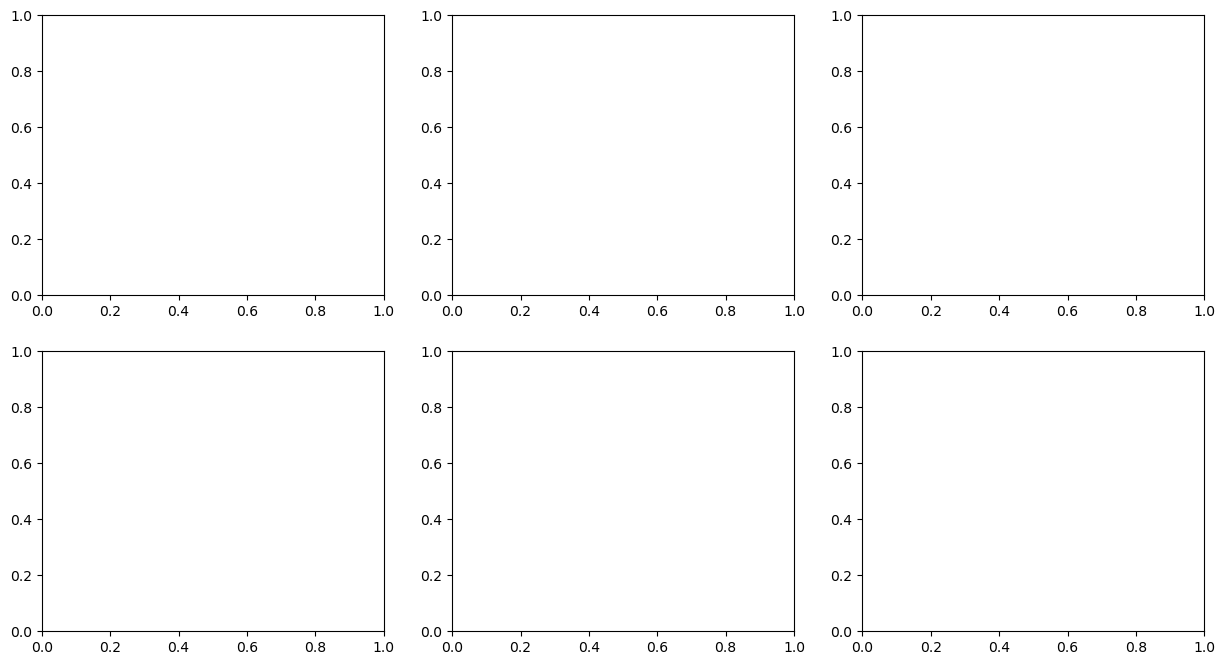

In [9]:
# Multimodal Medical Diagnosis System - Data Preparation
# MVP for Pneumonia Detection using X-rays and Medical Transcriptions

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random
import re

# For text processing - with necessary NLTK downloads
import nltk
# Download needed NLTK packages first!
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

# For image processing
from skimage import io
from skimage.transform import resize

# For model preparation
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Define paths
base_path = 'data'
chest_xray_path = os.path.join(base_path, 'chest_xray')
mtsample_path = os.path.join(base_path, 'mtsamples.csv')

print("Notebook configuration complete!")

# 1. Image Data Processing - Using existing structure

def process_existing_xray_structure(base_path):
    """Process X-ray images with existing train/test/val directories."""
    dataset_info = {}
    
    # Process each split (train, test, val)
    for split in ['train', 'test', 'val']:
        split_path = os.path.join(base_path, split)
        if not os.path.exists(split_path):
            print(f"Warning: {split} directory not found")
            continue
        
        normal_path = os.path.join(split_path, 'NORMAL')
        pneumonia_path = os.path.join(split_path, 'PNEUMONIA')
        
        # Count images in each class
        if os.path.exists(normal_path):
            normal_images = [f for f in os.listdir(normal_path) 
                            if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        else:
            normal_images = []
            
        if os.path.exists(pneumonia_path):
            pneumonia_images = [f for f in os.listdir(pneumonia_path) 
                              if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        else:
            pneumonia_images = []
        
        # Store paths and labels
        normal_paths = [os.path.join(normal_path, img) for img in normal_images]
        pneumonia_paths = [os.path.join(pneumonia_path, img) for img in pneumonia_images]
        
        all_paths = normal_paths + pneumonia_paths
        all_labels = [0] * len(normal_paths) + [1] * len(pneumonia_paths)
        
        dataset_info[split] = {
            'paths': all_paths,
            'labels': all_labels,
            'normal_count': len(normal_images),
            'pneumonia_count': len(pneumonia_images)
        }
        
        print(f"{split.capitalize()} set:")
        print(f"  NORMAL: {len(normal_images)} images")
        print(f"  PNEUMONIA: {len(pneumonia_images)} images")
    
    return dataset_info

# Process the image data
print("Processing X-ray image data:")
image_data = process_existing_xray_structure(chest_xray_path)

# Create a function to load and preprocess images
def preprocess_image(image_path, target_size=(224, 224)):
    """Load and preprocess an image for deep learning models."""
    img = Image.open(image_path).convert('RGB')
    img = img.resize(target_size)
    img_array = np.array(img) / 255.0  # Normalize to [0,1]
    return img_array

# Visualize sample images from each class
def visualize_samples(dataset_info, split='train', num_samples=3):
    """Visualize sample images from each class."""
    if split not in dataset_info:
        print(f"Split '{split}' not found in dataset")
        return
    
    paths = dataset_info[split]['paths']
    labels = dataset_info[split]['labels']
    
    pneumonia_indices = [i for i, label in enumerate(labels) if label == 1]
    normal_indices = [i for i, label in enumerate(labels) if label == 0]
    
    pneumonia_samples = random.sample(pneumonia_indices, min(num_samples, len(pneumonia_indices)))
    normal_samples = random.sample(normal_indices, min(num_samples, len(normal_indices)))
    
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 8))
    
    for i, idx in enumerate(normal_samples):
        img = preprocess_image(paths[idx])
        axes[0, i].imshow(img)
        axes[0, i].set_title('Normal')
        axes[0, i].axis('off')
    
    for i, idx in enumerate(pneumonia_samples):
        img = preprocess_image(paths[idx])
        axes[1, i].imshow(img)
        axes[1, i].set_title('Pneumonia')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize sample images
print("\nVisualizing sample X-ray images:")
visualize_samples(image_data)

# 2. Text Data Processing

# Load the MTSamples dataset
def load_mtsamples():
    """Load and display info about the MTSamples dataset."""
    df = pd.read_csv(mtsample_path)
    print(f"Dataset shape: {df.shape}")
    print("\nColumns:")
    for col in df.columns:
        print(f"- {col}")
    print("\nSample data:")
    return df

print("\nLoading MTSamples dataset:")
mtsamples_df = load_mtsamples()
print(mtsamples_df.head())

# Helper function to find pneumonia/respiratory related samples
def find_relevant_samples(df, keywords, column='transcription'):
    """Find samples containing relevant keywords."""
    pattern = '|'.join(keywords)
    mask = df[column].str.contains(pattern, case=False, na=False)
    return df[mask]

# Define relevant keywords for pneumonia
pneumonia_keywords = [
    'pneumonia', 'lung infection', 'chest infection', 'respiratory infection',
    'infiltrate', 'consolidation', 'pulmonary', 'respiratory'
]

# Filter relevant samples
print("\nFiltering for pneumonia-related text data:")
relevant_samples = find_relevant_samples(mtsamples_df, pneumonia_keywords)
print(f"Number of relevant samples found: {len(relevant_samples)}")

# Preprocess text data - simplified version without lemmatization
def preprocess_text_simple(text):
    """Basic text preprocessing without using WordNet lemmatizer."""
    if pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and digits
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    return ' '.join(tokens)

# Apply preprocessing to all relevant samples
print("\nPreprocessing text data:")
relevant_samples['processed_text'] = relevant_samples['transcription'].apply(preprocess_text_simple)

# Example text preprocessing
if len(relevant_samples) > 0:
    sample_text = relevant_samples.iloc[0]['transcription']
    print("\nOriginal text sample:")
    print(sample_text[:500], "...\n")
    
    processed_text = preprocess_text_simple(sample_text)
    print("Processed text sample:")
    print(processed_text[:500], "...")

# 3. Save Processed Data
def save_data_splits(image_data, text_data, output_dir='processed_data'):
    """Save the processed data for later use."""
    os.makedirs(output_dir, exist_ok=True)
    
    # Save image paths and labels
    for split_name, split_data in image_data.items():
        split_dir = os.path.join(output_dir, split_name)
        os.makedirs(split_dir, exist_ok=True)
        
        # Save image paths and labels
        pd.DataFrame({
            'image_path': split_data['paths'],
            'label': split_data['labels']
        }).to_csv(os.path.join(split_dir, 'image_data.csv'), index=False)
    
    # Save text data
    text_data.to_csv(os.path.join(output_dir, 'processed_text.csv'), index=False)
    
    print(f"Data saved to {output_dir}")

# Save the processed data
print("\nSaving processed data:")
save_data_splits(image_data, relevant_samples)

# 4. Summary and Next Steps
print("\nData Preparation Summary:")
print("1. Processed X-ray images from existing train/val/test splits")
print("2. Identified relevant text samples from MTSamples")
print("3. Saved processed data for model training")
print("\nNext Steps:")
print("1. Train baseline models for each modality")
print("2. Design fusion architecture")
print("3. Evaluate combined model performance")

# X-ray Classification Model

In [ ]:
# Pneumonia Detection - PyTorch X-ray Model
# Building a CNN model for pneumonia detection from chest X-rays using PyTorch

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
from tqdm import tqdm

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths to the processed data
BASE_PATH = 'processed_data'
BATCH_SIZE = 32
NUM_EPOCHS = 20

# 1. Define the dataset class
class ChestXrayDataset(Dataset):
    """Dataset for chest X-ray images."""
    
    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (str): Path to the csv file with image paths and labels.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data_frame = pd.read_csv(csv_file)
        self.transform = transform
    
    def __len__(self):
        return len(self.data_frame)
    
    def __getitem__(self, idx):
        img_path = self.data_frame.iloc[idx, 0]  # first column contains image paths
        image = Image.open(img_path).convert('RGB')
        
        label = self.data_frame.iloc[idx, 1]  # second column contains labels
        label = torch.tensor(label, dtype=torch.float32)
        
        if self.transform:
            image = self.transform(image)
        
        return image, label
    
class RobustChestXrayDataset(Dataset):
    """Dataset for chest X-ray images with robustness against corrupted images."""
    
    def __init__(self, csv_file, transform=None, fallback_image=None):
        """
        Args:
            csv_file (str): Path to the csv file with image paths and labels.
            transform (callable, optional): Optional transform to be applied on a sample.
            fallback_image (str, optional): Path to a fallback image to use for corrupted images.
                If None, will use a random valid image from the dataset.
        """
        self.data_frame = pd.read_csv(csv_file)
        self.transform = transform
        self.fallback_image = fallback_image
        self.valid_indices = list(range(len(self.data_frame)))
        self.corrupted_images = set()
        
        # Check for corrupted images during initialization
        self._validate_images()
        
        # Print dataset statistics
        print(f"Dataset initialized with {len(self.valid_indices)} valid images.")
        if self.corrupted_images:
            print(f"Found {len(self.corrupted_images)} corrupted images.")
    
    def _validate_images(self):
        """Validate all images in the dataset and identify corrupted ones."""
        valid_images = []
        self.corrupted_images = set()
        
        for idx in range(len(self.data_frame)):
            img_path = self.data_frame.iloc[idx, 0]
            try:
                with Image.open(img_path) as img:
                    img.verify()  # Verify image is not corrupted
                valid_images.append(idx)
            except (UnidentifiedImageError, OSError, IOError) as e:
                self.corrupted_images.add(idx)
                logging.warning(f"Corrupted image at index {idx}: {img_path}, Error: {e}")
        
        self.valid_indices = valid_images
        
        # If no fallback image is provided, use the first valid image
        if not self.fallback_image and valid_images:
            self.fallback_image = self.data_frame.iloc[valid_images[0], 0]
    
    def __len__(self):
        """Return the number of valid images in the dataset."""
        return len(self.valid_indices)
    
    def __getitem__(self, idx):
        """Get a sample from the dataset."""
        # Map the filtered index to the original index
        mapped_idx = self.valid_indices[idx]
        
        img_path = self.data_frame.iloc[mapped_idx, 0]
        try:
            image = Image.open(img_path).convert('RGB')
        except (UnidentifiedImageError, OSError, IOError) as e:
            # This should not happen since we filtered out corrupted images
            # But just in case, use the fallback image
            logging.error(f"Failed to load supposedly valid image: {img_path}, Error: {e}")
            if self.fallback_image:
                image = Image.open(self.fallback_image).convert('RGB')
            else:
                # Create a blank image as last resort
                image = Image.new('RGB', (224, 224), color=(128, 128, 128))
        
        label = self.data_frame.iloc[mapped_idx, 1]  # second column contains labels
        label = torch.tensor(label, dtype=torch.float32)
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


# 2. Define data transformations
def get_transforms():
    """Define data transformations for training and validation/testing."""
    # Training transformations with augmentation
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Validation/test transformations (no augmentation)
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    return train_transform, val_transform

# 3. Create dataloaders
def create_dataloaders():
    """Create PyTorch dataloaders for training, validation, and testing."""
    train_transform, val_transform = get_transforms()
    
    # Create datasets
    train_dataset = ChestXrayDataset(
        csv_file=os.path.join(BASE_PATH, 'train', 'image_data.csv'),
        transform=train_transform
    )
    
    val_dataset = ChestXrayDataset(
        csv_file=os.path.join(BASE_PATH, 'val', 'image_data.csv'),
        transform=val_transform
    )
    
    test_dataset = ChestXrayDataset(
        csv_file=os.path.join(BASE_PATH, 'test', 'image_data.csv'),
        transform=val_transform
    )
    
    # Create dataloaders
    # Setting num_workers=0 to avoid the multiprocessing issue
    train_loader = DataLoader(
        train_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=True, 
        num_workers=0
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=False, 
        num_workers=0
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=False, 
        num_workers=0
    )
    
    # Print dataset information
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")
    
    return train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset

# 4. Define the model using transfer learning
class PneumoniaClassifier(nn.Module):
    """CNN model for pneumonia classification using transfer learning."""
    
    def __init__(self, base_model_name='densenet121', pretrained=True, freeze_base=True):
        """
        Args:
            base_model_name (str): Name of the base model to use.
            pretrained (bool): Whether to use pretrained weights.
            freeze_base (bool): Whether to freeze the base model layers.
        """
        super(PneumoniaClassifier, self).__init__()
        
        # Load the base model
        if base_model_name == 'densenet121':
            self.base_model = models.densenet121(weights='IMAGENET1K_V1' if pretrained else None)
            num_ftrs = self.base_model.classifier.in_features
            self.base_model.classifier = nn.Identity()
        elif base_model_name == 'resnet50':
            self.base_model = models.resnet50(weights='IMAGENET1K_V1' if pretrained else None)
            num_ftrs = self.base_model.fc.in_features
            self.base_model.fc = nn.Identity()
        else:
            raise ValueError(f"Unsupported base model: {base_model_name}")
        
        # Freeze the base model if requested
        if freeze_base:
            for param in self.base_model.parameters():
                param.requires_grad = False
        
        # Custom classifier for pneumonia detection
        self.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1)
        )
        
        self.base_model_name = base_model_name
    
    def forward(self, x):
        """Forward pass."""
        features = self.base_model(x)
        return self.classifier(features)
    
    def unfreeze_layers(self, num_layers=10):
        """Unfreeze the last num_layers of the base model for fine-tuning."""
        if self.base_model_name == 'densenet121':
            layers = list(self.base_model.features.children())
            for layer in layers[-num_layers:]:
                for param in layer.parameters():
                    param.requires_grad = True
        elif self.base_model_name == 'resnet50':
            layers = list(self.base_model.children())
            for layer in layers[-num_layers:]:
                for param in layer.parameters():
                    param.requires_grad = True

# 5. Define training and validation functions
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train the model for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Progress bar
    pbar = tqdm(dataloader, desc="Training")
    
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * inputs.size(0)
        predictions = torch.sigmoid(outputs) >= 0.5
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
        
        # Update progress bar
        pbar.set_postfix({"loss": loss.item(), "acc": correct/total})
    
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    """Validate the model."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            predictions = torch.sigmoid(outputs) >= 0.5
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
            
            # Store predictions and labels for metrics
            all_preds.extend(torch.sigmoid(outputs).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct / total
    
    # Calculate AUC
    fpr, tpr, _ = roc_curve(all_labels, all_preds)
    roc_auc = auc(fpr, tpr)
    
    return epoch_loss, epoch_acc, roc_auc, all_preds, all_labels

# 6. Training loop with early stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, 
                num_epochs=NUM_EPOCHS, patience=5):
    """Train and validate the model with early stopping."""
    best_val_auc = 0.0
    best_model_wts = None
    no_improve_epochs = 0
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [], 'val_auc': []
    }
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # Training phase
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        
        # Validation phase
        val_loss, val_acc, val_auc, _, _ = validate(model, val_loader, criterion, device)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_auc'].append(val_auc)
        
        # Step the scheduler if provided
        if scheduler is not None:
            scheduler.step()
        
        # Print epoch results
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val AUC: {val_auc:.4f}")
        
        # Check if this is the best model so far
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            best_model_wts = model.state_dict().copy()
            no_improve_epochs = 0
            print(f"New best model with Val AUC: {val_auc:.4f}")
        else:
            no_improve_epochs += 1
            print(f"No improvement for {no_improve_epochs} epochs")
        
        # Early stopping
        if no_improve_epochs >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break
    
    # Load the best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

# Main execution code
if __name__ == "__main__":
    # Create dataloaders
    train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset = create_dataloaders()

    # Initialize the model
    model = PneumoniaClassifier(base_model_name='densenet121', pretrained=True, freeze_base=True)
    model = model.to(device)

    # Define loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model (first stage with frozen base layers)
    print("Training Stage 1: Frozen base model")
    model, history_stage1 = train_model(
        model, train_loader, val_loader, criterion, optimizer, None, num_epochs=10, patience=5
    )

    # Fine-tuning stage (unfreeze some layers)
    print("\nTraining Stage 2: Fine-tuning with unfrozen layers")
    model.unfreeze_layers(num_layers=10)  # Unfreeze the last 10 layers
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)

    model, history_stage2 = train_model(
        model, train_loader, val_loader, criterion, optimizer, None, num_epochs=10, patience=5
    )

    # Save the model
    torch.save(model.state_dict(), 'pneumonia_classifier.pth')
    print("Model saved to pneumonia_classifier.pth")

    # 8. Plot training history
    def plot_training_history(history_stage1, history_stage2=None):
        """Plot the training and validation metrics."""
        # Combine histories if we have two stages
        if history_stage2:
            train_loss = history_stage1['train_loss'] + history_stage2['train_loss']
            val_loss = history_stage1['val_loss'] + history_stage2['val_loss']
            train_acc = history_stage1['train_acc'] + history_stage2['train_acc']
            val_acc = history_stage1['val_acc'] + history_stage2['val_acc']
            val_auc = history_stage1['val_auc'] + history_stage2['val_auc']
            epochs = range(1, len(train_loss) + 1)
            stage1_end = len(history_stage1['train_loss'])
        else:
            train_loss = history_stage1['train_loss']
            val_loss = history_stage1['val_loss']
            train_acc = history_stage1['train_acc']
            val_acc = history_stage1['val_acc']
            val_auc = history_stage1['val_auc']
            epochs = range(1, len(train_loss) + 1)
            stage1_end = len(train_loss)
        
        # Create figure with 2 subplots
        plt.figure(figsize=(15, 5))
        
        # Plot loss
        plt.subplot(1, 3, 1)
        plt.plot(epochs, train_loss, 'b-', label='Training Loss')
        plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
        if history_stage2:
            plt.axvline(x=stage1_end, color='g', linestyle='--', label='Start Fine-tuning')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        
        # Plot accuracy
        plt.subplot(1, 3, 2)
        plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
        plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
        if history_stage2:
            plt.axvline(x=stage1_end, color='g', linestyle='--', label='Start Fine-tuning')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        
        # Plot AUC
        plt.subplot(1, 3, 3)
        plt.plot(epochs, val_auc, 'r-', label='Validation AUC')
        if history_stage2:
            plt.axvline(x=stage1_end, color='g', linestyle='--', label='Start Fine-tuning')
        plt.title('Validation AUC')
        plt.xlabel('Epochs')
        plt.ylabel('AUC')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

    # Plot training history
    plot_training_history(history_stage1, history_stage2)

    # 9. Evaluate on the test set
    def evaluate_model(model, test_loader, criterion, device):
        """Evaluate the model on the test set."""
        # Get test predictions
        test_loss, test_acc, test_auc, test_preds, test_labels = validate(model, test_loader, criterion, device)
        
        # Print metrics
        print(f"\nTest Results:")
        print(f"Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}, AUC: {test_auc:.4f}")
        
        # Convert predictions to binary
        test_preds_binary = (np.array(test_preds) >= 0.5).astype(int)
        
        # Print classification report
        print("\nClassification Report:")
        print(classification_report(test_labels, test_preds_binary, target_names=['Normal', 'Pneumonia']))
        
        # Plot confusion matrix
        cm = confusion_matrix(test_labels, test_preds_binary)
        plt.figure(figsize=(8, 6))
        sns.heatmap(
            cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Pneumonia'], 
            yticklabels=['Normal', 'Pneumonia']
        )
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()
        
        # Plot ROC curve
        fpr, tpr, _ = roc_curve(test_labels, test_preds)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()
        
        return {
            'loss': test_loss,
            'accuracy': test_acc,
            'auc': test_auc,
            'predictions': test_preds,
            'labels': test_labels
        }

    # Evaluate on test set
    test_results = evaluate_model(model, test_loader, criterion, device)

    # 10. Visualize some predictions
    def visualize_predictions(model, test_dataset, num_samples=5):
        """Visualize some example predictions."""
        # Set the model to evaluation mode
        model.eval()
        
        # Randomly select samples
        indices = random.sample(range(len(test_dataset)), num_samples)
        
        # Create figure
        fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
        
        # Get the inverse transform to display images
        inv_normalize = transforms.Compose([
            transforms.Normalize(
                mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                std=[1/0.229, 1/0.224, 1/0.225]
            ),
            transforms.ToPILImage()
        ])
        
        with torch.no_grad():
            for i, idx in enumerate(indices):
                # Get the image and label
                image, label = test_dataset[idx]
                image_tensor = image.unsqueeze(0).to(device)
                
                # Make prediction
                output = model(image_tensor).squeeze()
                pred_prob = torch.sigmoid(output).item()
                pred_class = "Pneumonia" if pred_prob >= 0.5 else "Normal"
                true_class = "Pneumonia" if label.item() == 1 else "Normal"
                
                # Color green for correct predictions, red for incorrect
                color = "green" if pred_class == true_class else "red"
                
                # Convert tensor to image for display
                img_to_show = inv_normalize(image.cpu())
                
                # Display the image and prediction
                axes[i].imshow(img_to_show)
                axes[i].set_title(f"Pred: {pred_class}\nTrue: {true_class}\nProb: {pred_prob:.2f}", color=color)
                axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()

    # Visualize some predictions
    visualize_predictions(model, test_dataset)

    # 11. Extract and save features for multimodal fusion
    def extract_features(model, dataloader, device):
        """Extract features from the model for the dataloader samples."""
        # Create a feature extractor model
        if isinstance(model, PneumoniaClassifier):
            # Create a copy of the model that outputs features before the final classification layer
            class FeatureExtractor(nn.Module):
                def __init__(self, model):
                    super(FeatureExtractor, self).__init__()
                    self.base_model = model.base_model
                    
                    # Get the feature extractor part (all but the last layer)
                    classifier_layers = list(model.classifier.children())
                    self.feature_layers = nn.Sequential(*classifier_layers[:-2])
                
                def forward(self, x):
                    features = self.base_model(x)
                    return self.feature_layers(features)
            
            feature_extractor = FeatureExtractor(model).to(device)
        else:
            raise ValueError("Unsupported model type for feature extraction")
        
        # Extract features
        feature_extractor.eval()
        features = []
        labels = []
        
        with torch.no_grad():
            for inputs, batch_labels in tqdm(dataloader, desc="Extracting features"):
                inputs = inputs.to(device)
                batch_features = feature_extractor(inputs)
                features.append(batch_features.cpu().numpy())
                labels.append(batch_labels.numpy())
        
        # Concatenate batches
        features = np.vstack(features)
        labels = np.concatenate(labels)
        
        return features, labels

    # Extract features for all sets
    print("\nExtracting features for future multimodal fusion:")
    train_features, train_labels = extract_features(model, train_loader, device)
    val_features, val_labels = extract_features(model, val_loader, device)
    test_features, test_labels = extract_features(model, test_loader, device)

    # Save features
    features_path = 'image_features.npz'
    np.savez(
        features_path,
        train_features=train_features, train_labels=train_labels,
        val_features=val_features, val_labels=val_labels,
        test_features=test_features, test_labels=test_labels
    )
    print(f"Features saved to {features_path}")

    # 12. Summary and conclusion
    print("\nImage Model Summary:")
    print(f"Architecture: DenseNet121 with custom classifier")
    print(f"Training strategy: Two-stage training with transfer learning")
    print(f"Test Accuracy: {test_results['accuracy']:.4f}")
    print(f"Test AUC: {test_results['auc']:.4f}")

    print("\nNext Steps:")
    print("1. Build a text model to extract key pneumonia indicators from medical text")
    print("2. Create a visualization dashboard showing X-ray predictions and text insights")
    print("3. Demonstrate how integrating both modalities improves diagnostic capability")

Using device: cpu


ValueError: num_samples should be a positive integer value, but got num_samples=0

In [2]:
def create_dataloaders():
    train_csv_path = os.path.join(BASE_PATH, 'train', 'image_data.csv')
    val_csv_path = os.path.join(BASE_PATH, 'val', 'image_data.csv')
    test_csv_path = os.path.join(BASE_PATH, 'test', 'image_data.csv')
    
    print(f"Checking if train CSV exists: {os.path.exists(train_csv_path)}")
    if os.path.exists(train_csv_path):
        df = pd.read_csv(train_csv_path)
        print(f"Train CSV shape: {df.shape}")
        print(f"Train CSV first few rows:\n{df.head()}")
    
    # Rest of the function...

In [ ]:
# Pneumonia Detection - Error Handling for Corrupted Images

import os
import pandas as pd
from PIL import Image, UnidentifiedImageError
import shutil

def identify_corrupted_images(csv_file):
    """Check all images in the CSV file and identify any corrupted ones."""
    df = pd.read_csv(csv_file)
    corrupted_images = []
    
    print(f"Checking {len(df)} images for corruption...")
    
    for idx, row in df.iterrows():
        img_path = row['image_path']
        try:
            # Try to open the image
            with Image.open(img_path) as img:
                # Try to load the image data
                img.load()
        except (UnidentifiedImageError, OSError, IOError) as e:
            print(f"Corrupted image found: {img_path}")
            print(f"Error: {e}")
            corrupted_images.append(img_path)
    
    return corrupted_images

def remove_corrupted_from_csv(csv_file, corrupted_images, output_file=None):
    """Remove corrupted images from the CSV file."""
    if not output_file:
        output_file = csv_file.replace('.csv', '_clean.csv')
    
    df = pd.read_csv(csv_file)
    
    # Filter out corrupted images
    clean_df = df[~df['image_path'].isin(corrupted_images)]
    
    # Save the clean dataframe
    clean_df.to_csv(output_file, index=False)
    
    print(f"Removed {len(corrupted_images)} corrupted images from CSV.")
    print(f"Original CSV had {len(df)} entries, new CSV has {len(clean_df)} entries.")
    print(f"Clean CSV saved to {output_file}")
    
    return clean_df

def check_and_clean_dataset():
    """Check all splits of the dataset and clean them."""
    base_path = 'processed_data'
    splits = ['train', 'val', 'test']
    
    for split in splits:
        csv_path = os.path.join(base_path, split, 'image_data.csv')
        
        if os.path.exists(csv_path):
            print(f"\nChecking {split} split...")
            corrupted = identify_corrupted_images(csv_path)
            
            if corrupted:
                # Make backup of original CSV
                backup_path = os.path.join(base_path, split, f'image_data_backup.csv')
                shutil.copy(csv_path, backup_path)
                print(f"Backup created at {backup_path}")
                
                # Remove corrupted images from CSV
                remove_corrupted_from_csv(csv_path, corrupted, csv_path)
            else:
                print(f"No corrupted images found in {split} split.")
        else:
            print(f"CSV file not found for {split} split: {csv_path}")

if __name__ == "__main__":
    check_and_clean_dataset()


Checking train split...
Checking 0 images for corruption...
No corrupted images found in train split.

Checking val split...
Checking 0 images for corruption...
No corrupted images found in val split.

Checking test split...
Checking 0 images for corruption...
No corrupted images found in test split.
